# Time Series Analysis of Solar Data

### Import packages

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

### Import data

In [19]:
df = pd.read_csv('../data/chart-data (25).csv', parse_dates=[0], index_col=0)

In [20]:
df.head()

,"Shark Meter, KWtotal Kilowatts","AE 500kW 1, AC Power Kilowatts","AE 500kW 2, AC Power Kilowatts",(Offline) Weather Station - POA (POA)* Watts/meter²,Weather Station (POA) (SO31456) (POA)* Watts/meter²,"RECx31 Weather Station, Module Temp Degrees Celsius","RECx31 Weather Station, Ambient Temp Degrees Celsius"
Site Time,,,,,,,
2020-01-01 00:00:00,0,0.0,0.0,16.963,NaN,4.990,6.045
2020-01-01 00:15:00,0,0.0,0.0,17.477,NaN,4.541,5.995
2020-01-01 00:30:00,0,0.0,0.0,17.296,NaN,4.293,5.839
2020-01-01 00:45:00,0,0.0,0.0,17.102,NaN,4.156,5.884
2020-01-01 01:00:00,0,0.0,0.0,16.946,NaN,3.867,5.828


In [21]:
df.shape

(35136, 7)

In [48]:
df.dtypes

Shark Meter, KWtotal Kilowatts                           object
AE 500kW 1, AC Power Kilowatts                          float64
AE 500kW 2, AC Power Kilowatts                          float64
(Offline) Weather Station - POA (POA)* Watts/meter²      object
Weather Station (POA) (SO31456) (POA)* Watts/meter²      object
RECx31 Weather Station, Module Temp Degrees Celsius     float64
RECx31 Weather Station, Ambient Temp Degrees Celsius    float64
dtype: object

We've got two columns which were read in as strings, probably because they have commas in them, so let's strip the commas.  

In [51]:
df.replace(',','', regex=True, inplace=True)
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')

In [52]:
df.dtypes

Shark Meter, KWtotal Kilowatts                          float64
AE 500kW 1, AC Power Kilowatts                          float64
AE 500kW 2, AC Power Kilowatts                          float64
(Offline) Weather Station - POA (POA)* Watts/meter²     float64
Weather Station (POA) (SO31456) (POA)* Watts/meter²     float64
RECx31 Weather Station, Module Temp Degrees Celsius     float64
RECx31 Weather Station, Ambient Temp Degrees Celsius    float64
dtype: object

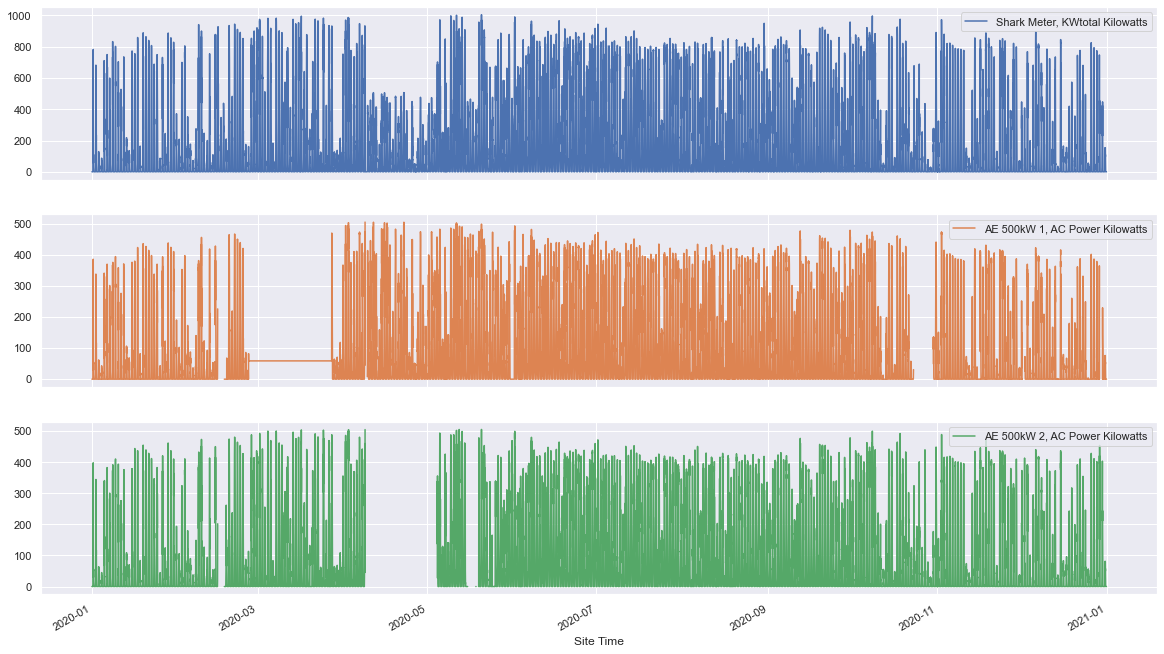

In [60]:
df[['Shark Meter, KWtotal Kilowatts','AE 500kW 1, AC Power Kilowatts','AE 500kW 2, AC Power Kilowatts']]\
        .plot(subplots=True, layout=(3,1), figsize=(20,12));

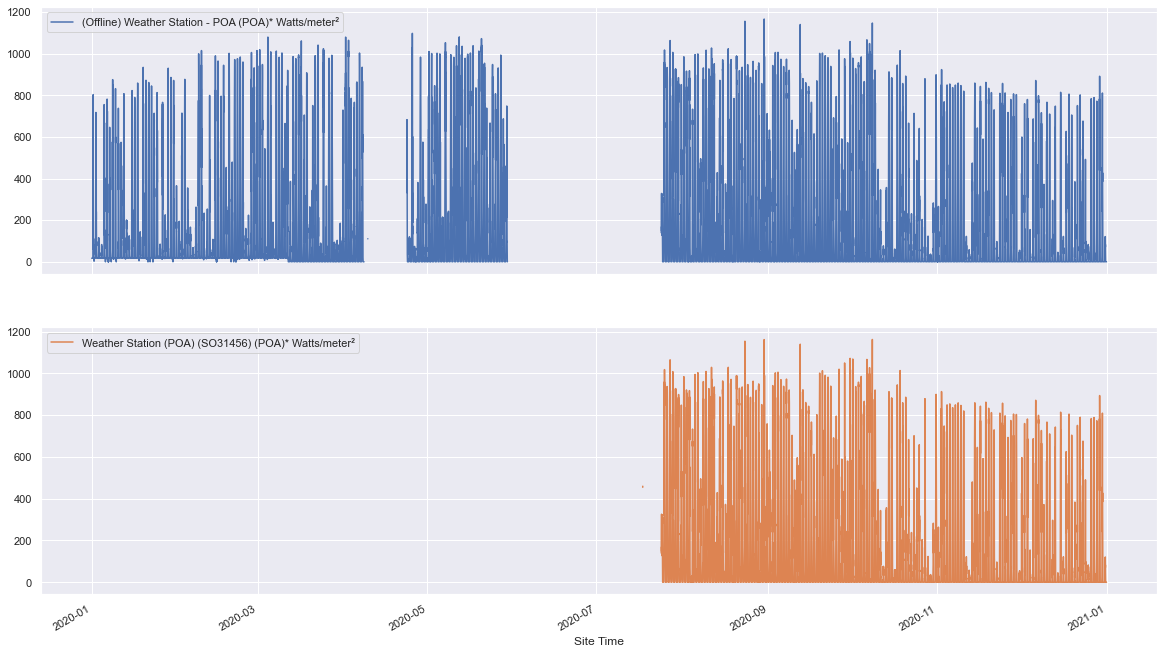

In [62]:
df[['(Offline) Weather Station - POA (POA)* Watts/meter²','Weather Station (POA) (SO31456) (POA)* Watts/meter²']]\
        .plot(subplots=True, layout=(2,1), figsize=(20,12));

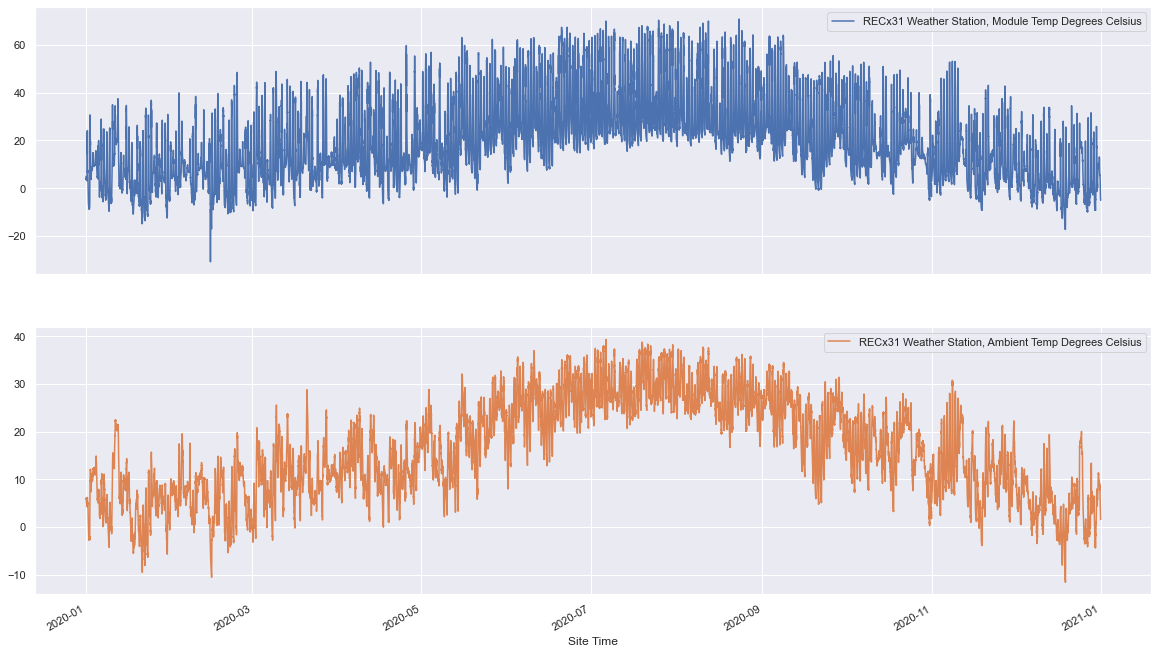

In [63]:
df[['RECx31 Weather Station, Module Temp Degrees Celsius','RECx31 Weather Station, Ambient Temp Degrees Celsius']]\
        .plot(subplots=True, layout=(2,1), figsize=(20,12));

There's not nearly as much annual seasonality as I would have expected. Let's look at daily seasonality.

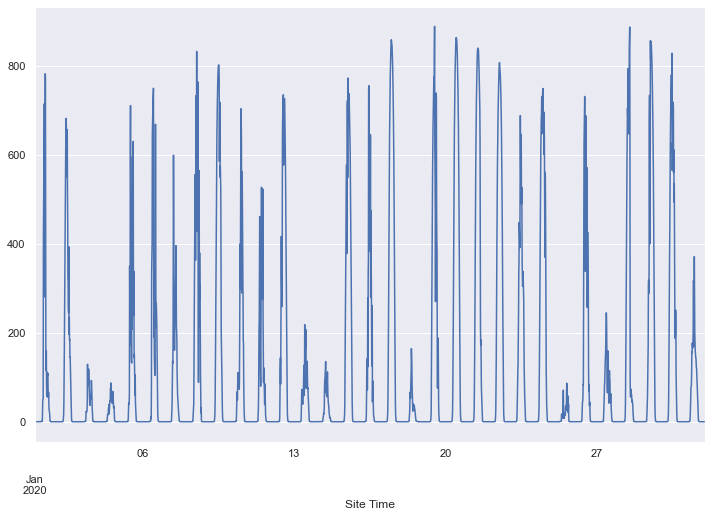

In [64]:
df.loc['2020-01-01':'2020-01-31','Shark Meter, KWtotal Kilowatts'].plot(figsize=(12,8));

Now we see the daily variation